# Justified Referral in AI Glaucoma Screening

In [2]:
!wget "https://zenodo.org/record/10035093/files/JustRAIGS_Train_labels.csv"

--2024-04-17 17:09:40--  https://zenodo.org/record/10035093/files/JustRAIGS_Train_labels.csv
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... 

connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/10035093/files/JustRAIGS_Train_labels.csv [following]
--2024-04-17 17:09:41--  https://zenodo.org/records/10035093/files/JustRAIGS_Train_labels.csv
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 9205084 (8.8M) [text/plain]
Saving to: ‘JustRAIGS_Train_labels.csv’

JustRAIGS_Train_lab 100%[===================>]   8.78M   198KB/s    in 23s     

2024-04-17 17:10:04 (390 KB/s) - ‘JustRAIGS_Train_labels.csv’ saved [9205084/9205084]



In [3]:
import gdown
gdown.download('https://drive.google.com/uc?id=16W842tGVVIrf-phN9msf4m-lRTvuyDAW', 'combine.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=16W842tGVVIrf-phN9msf4m-lRTvuyDAW
From (redirected): https://drive.google.com/uc?id=16W842tGVVIrf-phN9msf4m-lRTvuyDAW&confirm=t&uuid=1ee85c96-3cb4-4a9e-b6b3-14d4949015f6
To: /home/iiitd/Downloads/combine.zip
100%|██████████| 1.88G/1.88G [00:42<00:00, 43.8MB/s]


'combine.zip'

In [4]:
!unzip -nq 'combine.zip' -d 'images'

In [5]:
!ls 'images/combine' -l | wc -l

101424


## Start here

Importing libraries

In [6]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import keras
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import keras.layers as layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

2024-04-17 17:11:01.232903: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 17:11:01.233257: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 17:11:01.235060: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 17:11:01.258095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 17:11:01.669287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

 Set the seed for reproducibility for all the libraries

In [7]:
seed= 1
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

Load the dataset<br>
Load the CSV file

In [8]:
data = pd.read_csv('JustRAIGS_Train_labels.csv', delimiter=';')
# data = data[:17400]
data.head()

,Eye ID,Final Label,Fellow Eye ID,Age,Label G1,Label G2,Label G3,G1 ANRS,G1 ANRI,G1 RNFLDS,...,G3 ANRS,G3 ANRI,G3 RNFLDS,G3 RNFLDI,G3 BCLVS,G3 BCLVI,G3 NVT,G3 DH,G3 LD,G3 LC
0,TRAIN000000,NRG,TRAIN081848,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN000001,NRG,TRAIN018312,29.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAIN000002,NRG,TRAIN083822,61.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN000003,NRG,TRAIN055721,70.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TRAIN000004,NRG,TRAIN099283,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Preprocess the dataset<br>
Check for missing values

In [9]:
data.iloc[:,:4].isnull().sum()

Eye ID              0
Final Label         0
Fellow Eye ID    8406
Age                14
dtype: int64

Handle missing values in the 'Age' column

In [10]:
data['Age'] = data['Age'].fillna(data['Age'].mean())
data.iloc[:,:4].isnull().sum()

Eye ID              0
Final Label         0
Fellow Eye ID    8406
Age                 0
dtype: int64

Check for class imbalance

Final Label
NRG    98153
RG      3270
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='Final Label'>

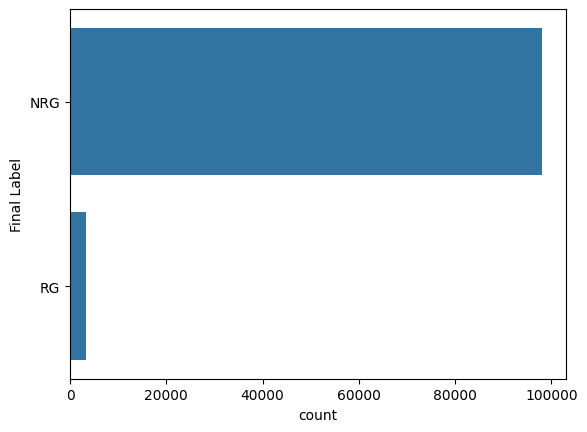

In [11]:
print(data['Final Label'].value_counts())
sns.countplot(data['Final Label'])

Visualize the dataset

Create a column 'File Path' in the dataframe

In [12]:
image_directory= 'images/combine'
def get_extension(eye_id):
    for ext in ['.JPG', '.JPEG', '.PNG']:  # Check for common image extensions
        image_path = os.path.join(image_directory, f"{eye_id}{ext}")
        if os.path.exists(image_path):
            return f"{ext}"
    print(f"Image not found for {eye_id}")
    return None

In [13]:
# add column File Path
data['Extention'] = data['Eye ID'].apply(lambda x: get_extension(x))
data['File Path'] = 'images/combine/' + data['Eye ID'] + data['Extention']

In [14]:
data

,Eye ID,Final Label,Fellow Eye ID,Age,Label G1,Label G2,Label G3,G1 ANRS,G1 ANRI,G1 RNFLDS,...,G3 RNFLDS,G3 RNFLDI,G3 BCLVS,G3 BCLVI,G3 NVT,G3 DH,G3 LD,G3 LC,Extention,File Path
0,TRAIN000000,NRG,TRAIN081848,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,images/combine/TRAIN000000.JPG
1,TRAIN000001,NRG,TRAIN018312,29.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,images/combine/TRAIN000001.JPG
2,TRAIN000002,NRG,TRAIN083822,61.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,images/combine/TRAIN000002.JPG
3,TRAIN000003,NRG,TRAIN055721,70.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,images/combine/TRAIN000003.JPG
4,TRAIN000004,NRG,TRAIN099283,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,images/combine/TRAIN000004.JPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101418,TRAIN101437,NRG,TRAIN096656,57.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,images/combine/TRAIN101437.JPG
101419,TRAIN101438,NRG,TRAIN078075,52.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,images/combine/TRAIN101438.JPG
101420,TRAIN101439,NRG,TRAIN056754,49.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,images/combine/TRAIN101439.JPG
101421,TRAIN101440,NRG,TRAIN040796,44.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,images/combine/TRAIN101440.JPG


In [15]:
import matplotlib.image as mpimg
def crop_rgb(img_path):

    # Load the image
    img = plt.imread(img_path)

    # Initialize crop boundaries to cover the entire image
    top, bottom, left, right = 0, img.shape[0], 0, img.shape[1]
    centre = img.shape[0] // 2, img.shape[1] // 2

    # Find the leftmost non-black column
    for i in range(centre[1], -1, -1):
        if np.sum(img[centre[0], i, :]) < 10:  # Assuming non-black pixels have a sum greater than 10
            left_shift = centre[1] - i
            break

    # Find the rightmost non-black column
    for i in range(centre[1], img.shape[1]):
        if np.sum(img[centre[0], i, :]) < 10:
            right_shift = i - centre[1]
            break

    # Update the crop boundaries
    shift= max(left_shift, right_shift)
    left = centre[1] - shift
    right = centre[1] + shift

    # Crop in a 3:5 ratio
    width = right - left
    new_height = int(width * 0.60)
    centre = img.shape[0] // 2
    top = max(0, centre - (new_height // 2))
    bottom = min(img.shape[0], centre + (new_height // 2))

    # Crop the image
    cropped_img = img[top:bottom, left:right, :]

    # Convert the cropped image to grayscale
    # grayscale_img = np.dot(cropped_img[..., :3], [0.2989, 0.5870, 0.1140])

    # Display the cropped image
    # plt.imshow(cropped_img)
    # plt.axis('off')
    # plt.show()

    # return cropped image
    return cropped_img

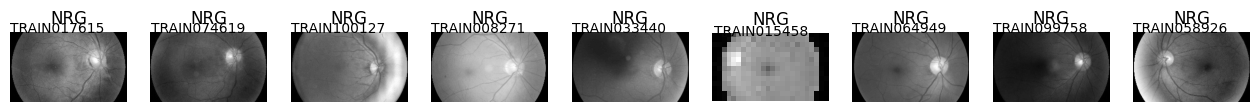

In [16]:
plt.figure(figsize=(16, 10))
for i in range(9):
    plt.subplot(1, 9, i+1)
    try:
        index= random.randint(0, len(data))
        # img = plt.imread(data.loc[index, 'File Path'])
        # crop the image to 3:4 aspect ratio from the center
        # img = img[0: int(img.shape[0]*3/4), :]

        # img= crop_rgb(data['File Path'][index])
        img_path = 'images/combine/' + data['Eye ID'][index] + data['Extention'][index]
        img= crop_rgb(img_path)
        # convert to grayscale
        # img = plt.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        cv2.imwrite(f'temp/{index}.jpg', gray_img)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
        plt.title(data['Final Label'][index])
        plt.text(0, 0, data['Eye ID'][index])
    except:
        print('Error: '+ 'images/combine/' + data['Eye ID'][index] + data['Extention'][index])
plt.show()

In [17]:
# !rm -rf 'cropped_images'

In [18]:
# crop all images and save them in a new directory
new_directory= 'cropped_images'
if not os.path.exists(new_directory):
    os.makedirs(new_directory)
for i in range(len(data)):
    try:
        img= crop_rgb(data['File Path'][i])
        # convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        cv2.imwrite(os.path.join(new_directory, f"{data['Eye ID'][i]}{data['Extention'][i]}"), gray_img)
    except:
        # print(f'Error: {data.loc[i, "File Path"]}')
        data.drop(i, inplace=True)


In [19]:
data.shape

(99494, 39)

In [20]:
data['File Path'] = 'cropped_images/' + data['Eye ID'] + data['Extention']

In [21]:
data

,Eye ID,Final Label,Fellow Eye ID,Age,Label G1,Label G2,Label G3,G1 ANRS,G1 ANRI,G1 RNFLDS,...,G3 RNFLDS,G3 RNFLDI,G3 BCLVS,G3 BCLVI,G3 NVT,G3 DH,G3 LD,G3 LC,Extention,File Path
0,TRAIN000000,NRG,TRAIN081848,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000000.JPG
1,TRAIN000001,NRG,TRAIN018312,29.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000001.JPG
2,TRAIN000002,NRG,TRAIN083822,61.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000002.JPG
3,TRAIN000003,NRG,TRAIN055721,70.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000003.JPG
4,TRAIN000004,NRG,TRAIN099283,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000004.JPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101418,TRAIN101437,NRG,TRAIN096656,57.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN101437.JPG
101419,TRAIN101438,NRG,TRAIN078075,52.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN101438.JPG
101420,TRAIN101439,NRG,TRAIN056754,49.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN101439.JPG
101421,TRAIN101440,NRG,TRAIN040796,44.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN101440.JPG


Split the dataset into training and validation sets

In [22]:
X = data[['Eye ID', 'Final Label', 'Fellow Eye ID', 'Age', 'File Path', 'Extention']]
y = data['Final Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)
print(X_train.shape, X_val.shape, X_test.shape)

(80589, 6) (8955, 6) (9950, 6)


 Handle the images<br>
Load and Augment the images corresponding to the 'Eye ID' column values from the folder using keras ImageDataGenerator and flow_from_dataframe

In [23]:
def get_image_generator(df, image_size=(128, 128), batch_size=32, shuffle=True):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        # width_shift_range=0.05,
        # height_shift_range=0.05,
        # zoom_range=0.2,
        # horizontal_flip=True,
        # fill_mode='nearest',
    )
    generator = datagen.flow_from_dataframe(
        df,
        x_col='File Path',
        y_col='Final Label',
        target_size=image_size,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=shuffle
    )
    return generator

In [24]:
from sklearn.utils import resample
X_train_rg = X_train[X_train['Final Label']=='RG']
X_train_nrg = X_train[X_train['Final Label']=='NRG']
X_train_rg.shape, X_train_nrg.shape

((2594, 6), (77995, 6))

In [25]:
X_train_rg_resampled= resample(X_train_rg, n_samples= 15000, random_state= seed)
X_train_nrg_resampled= resample(X_train_nrg, n_samples= 60000, random_state= seed)
X_train_rg_resampled.shape, X_train_nrg_resampled

((15000, 6),
             Eye ID Final Label Fellow Eye ID   Age  \
 48862  TRAIN048871         NRG   TRAIN090471  59.0   
 57508  TRAIN057519         NRG   TRAIN003913  63.0   
 52579  TRAIN052589         NRG   TRAIN029761  55.0   
 97109  TRAIN097127         NRG   TRAIN063181  62.0   
 37955  TRAIN037964         NRG   TRAIN070498  58.0   
 ...            ...         ...           ...   ...   
 48473  TRAIN048482         NRG   TRAIN099678  66.0   
 6073   TRAIN006073         NRG   TRAIN082938  45.0   
 81540  TRAIN081555         NRG   TRAIN073387  48.0   
 70281  TRAIN070293         NRG           NaN  47.0   
 65347  TRAIN065359         NRG   TRAIN078385  67.0   
 
                             File Path Extention  
 48862  cropped_images/TRAIN048871.JPG      .JPG  
 57508  cropped_images/TRAIN057519.JPG      .JPG  
 52579  cropped_images/TRAIN052589.JPG      .JPG  
 97109  cropped_images/TRAIN097127.JPG      .JPG  
 37955  cropped_images/TRAIN037964.JPG      .JPG  
 ...               

In [26]:
X_train_resampled = pd.concat([X_train_rg_resampled, X_train_nrg_resampled])
X_train_resampled.shape

(75000, 6)

In [27]:
# Define the ImageDataGenerator for oversampled data
train_generator = get_image_generator(X_train_resampled, image_size=(120, 200), batch_size=64, shuffle=True)

Found 75000 validated image filenames belonging to 2 classes.


In [28]:
# train_generator = get_image_generator(X_train, image_size=(90, 150), batch_size=32, shuffle=True)
val_generator = get_image_generator(X_val, image_size=(120, 200), batch_size=64, shuffle=False)

Found 8955 validated image filenames belonging to 2 classes.


Display the images after oversampling and data augmentation

In [29]:
test_generator = get_image_generator(X_test, image_size=(120, 200), batch_size=64, shuffle=False)

Found 9950 validated image filenames belonging to 2 classes.


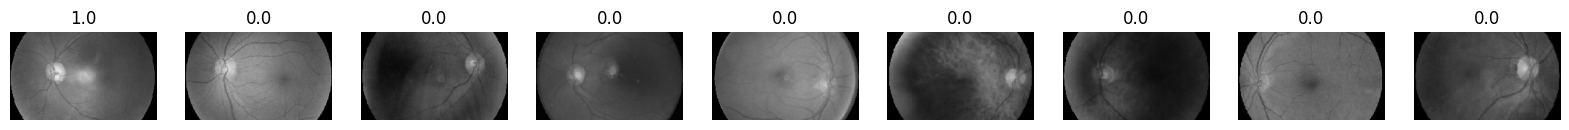

In [30]:
plt.figure(figsize=(20, 10))
for x_batch, y_batch in train_generator:
    for i in range(9):
        plt.subplot(1, 9, i+1)
        plt.imshow(x_batch[i])
        plt.title(y_batch[i])
        plt.axis('off')
    break

Display the class distribution after oversampling and data augmentation

In [31]:
print(f'train 0: {train_generator.classes.count(0)}\ntrain 1: {train_generator.classes.count(1)}')

train 0: 60000
train 1: 15000


In [32]:
imbalance_ratio= (train_generator.classes.count(0)// train_generator.classes.count(1))
print(imbalance_ratio)

4


In [33]:
print(f'val 0: {val_generator.classes.count(0)}\nval 1: {val_generator.classes.count(1)}')

val 0: 8667
val 1: 288


 Model Building<br>
Create a CNN model from scratch

In [34]:
from tensorflow.keras.layers import Input
from keras.applications import VGG16, DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

def get_model(input_shape):
    # input_layer = Input(shape=input_shape)
    # base_model = VGG16(include_top=False, input_tensor=input_layer)

    # for layer in base_model.layers:
    #     layer.trainable = False

    # x = Flatten()(base_model.output)
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.1)(x)
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.1)(x)
    # output = Dense(1, activation='sigmoid')(x)

    # # Create the model
    # model = Model(inputs=base_model.input, outputs=output)

    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # layers.Conv2D(128, (3, 3), activation='relu'),
        # layers.AveragePooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(), 
        layers.Dropout(0.1),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(), 
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
    return model

In [35]:
model = get_model((120,200, 3))
model.summary()

/home/iiitd/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86016)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,010,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,047,233 (42.14 MB)

 Trainable params: 11,046,721 (42.14 MB)

 Non-trainable params: 512 (2.00 KB)

In [36]:
weight = {0:1,1:imbalance_ratio}

In [37]:
best_model= load_model('monitor01model.h5')

In [38]:
def evaluate_model(model, data_generator, dataset_name='Train'):
    predictions = model.predict(data_generator)
    predictions_prob = predictions # Save the probabilities for ROC curve
    predictions = (predictions > 0.5).astype(int)
    true_labels = data_generator.classes
    print(f"\nMetrics for {dataset_name} Data:")
    print("Accuracy: ", accuracy_score(true_labels, predictions))
    print("Precision: ", precision_score(true_labels, predictions))
    print("Recall: ", recall_score(true_labels, predictions))
    print("F1-Score: ", f1_score(true_labels, predictions))
    print("AUC: ", roc_auc_score(true_labels, predictions_prob))
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, predictions_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Desired specificity
    desired_specificity = 0.95
    idx = np.argmax(fpr >= (1 - desired_specificity))
    threshold_at_desired_specificity = thresholds[idx]
    sensitivity_at_desired_specificity = tpr[idx]

    print(f"Threshold at Specificity {desired_specificity*100:.2f}%: {threshold_at_desired_specificity:.4f}")
    print(f"Sensitivity at Specificity {desired_specificity*100:.2f}%: {sensitivity_at_desired_specificity:.4f}")


/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 124s 105ms/step

Metrics for Train Data:
Accuracy:  0.7282
Precision:  0.2041533897373915
Recall:  0.12386666666666667
F1-Score:  0.15418447367329158
AUC:  0.49963454166666665


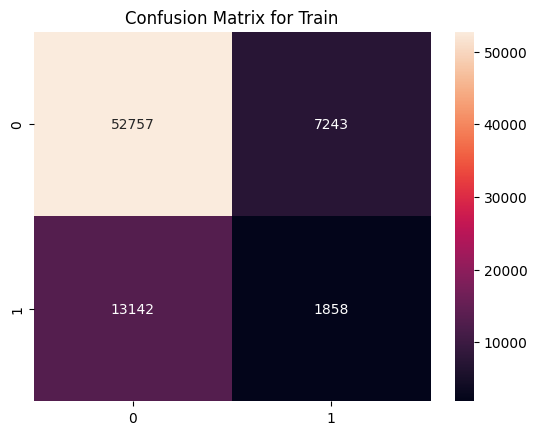

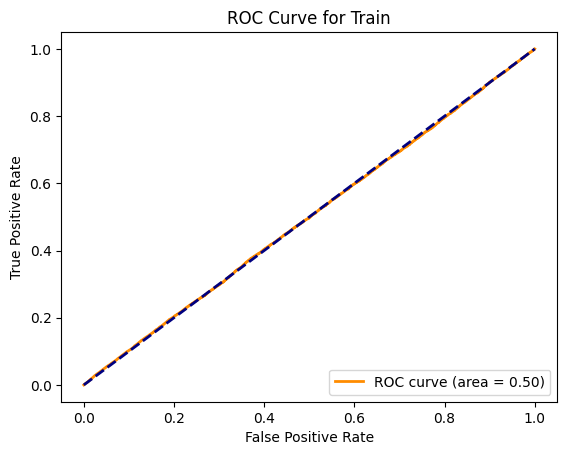

Threshold at Specificity 95.00%: 0.9906
Sensitivity at Specificity 95.00%: 0.0535


In [39]:
# Evaluate on Train, Validation, and Test Data
evaluate_model(best_model, train_generator, 'Train')

  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step

/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step

Metrics for Validation Data:
Accuracy:  0.9634840871021776
Precision:  0.22535211267605634
Recall:  0.05555555555555555
F1-Score:  0.08913649025069638
AUC:  0.7772405388254298


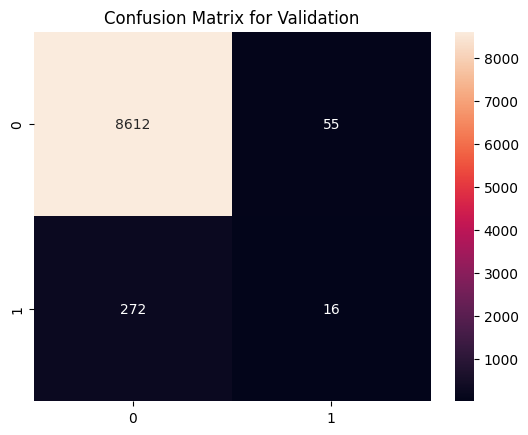

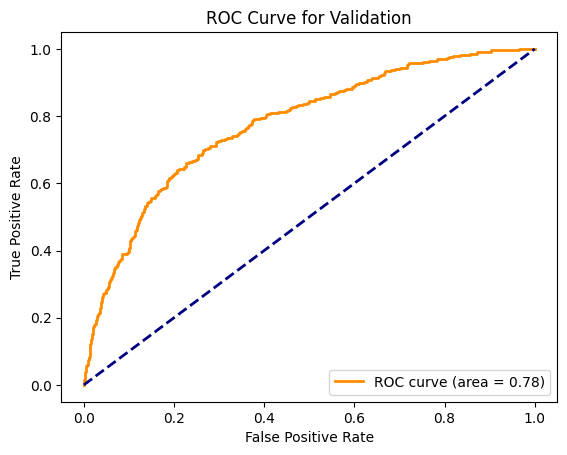

Threshold at Specificity 95.00%: 0.0100
Sensitivity at Specificity 95.00%: 0.2812


In [40]:
evaluate_model(best_model, val_generator, 'Validation')


  1/156 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step

/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step

Metrics for Test Data:
Accuracy:  0.9644221105527638
Precision:  0.2638888888888889
Recall:  0.059375
F1-Score:  0.09693877551020408
AUC:  0.7512470794392524


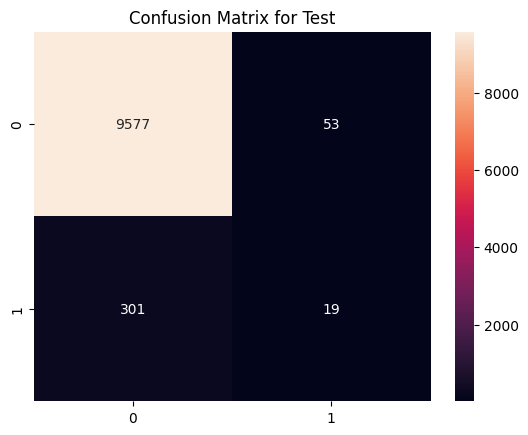

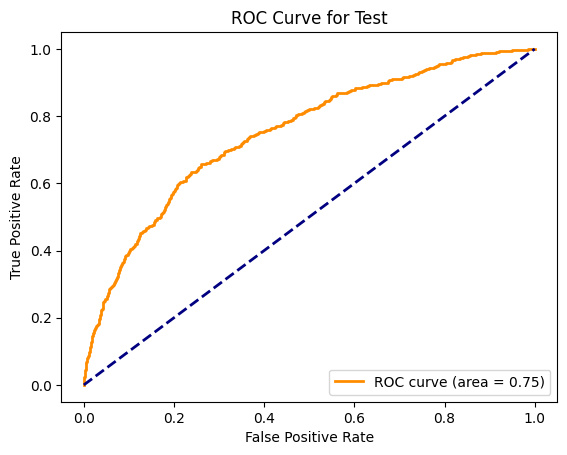

Threshold at Specificity 95.00%: 0.0092
Sensitivity at Specificity 95.00%: 0.2562


In [41]:
evaluate_model(best_model, test_generator, 'Test')

Monitor 1

In [42]:
X_train_rg_resampled= resample(X_train_rg, n_samples= X_train_nrg.shape[0], random_state= seed)
X_train_rg_resampled.shape

(77995, 6)

In [43]:
X_train_resampled = pd.concat([X_train_rg_resampled, X_train_nrg])
X_train_resampled.shape

(155990, 6)

In [44]:
# Define the ImageDataGenerator for oversampled data
train_generator = get_image_generator(X_train_resampled, image_size=(120, 200), batch_size=64, shuffle=True)

Found 155990 validated image filenames belonging to 2 classes.


In [45]:
# train_generator = get_image_generator(X_train, image_size=(90, 150), batch_size=32, shuffle=True)
val_generator = get_image_generator(X_val, image_size=(120, 200), batch_size=64, shuffle=False)

Found 8955 validated image filenames belonging to 2 classes.


In [55]:
from tensorflow.keras.layers import Input
from keras.applications import VGG16, DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

def get_model(input_shape):
    input_layer = Input(shape=input_shape)
    base_model = VGG16(include_top=False, input_tensor=input_layer)

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    # x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    # x = Dropout(0.1)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

    # model = keras.Sequential([
    #     layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    #     layers.AveragePooling2D((2, 2)),
    #     layers.Conv2D(64, (3, 3), activation='relu'),
    #     layers.AveragePooling2D((2, 2)),
    #     layers.Conv2D(128, (3, 3), activation='relu'),
    #     layers.AveragePooling2D((2, 2)),
    #     layers.Flatten(),
    #     layers.Dense(128, activation='relu'),
    #     layers.Dropout(0.1),
    #     layers.Dense(128, activation='relu'),
    #     layers.Dropout(0.1),
    #     layers.Dense(1, activation='sigmoid')
    # ])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
    return model

In [56]:
model = get_model((120,200, 3))
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 120, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 120, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 120, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 60, 100, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 60, 100, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 60, 100, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 30, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 30, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 30, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 30, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 15, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 15, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 15, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 15, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 7, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,911,105 (60.70 MB)

 Trainable params: 1,196,417 (4.56 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [57]:
weight= {0: 1, 1: imbalance_ratio}

In [58]:
from keras.models import load_model

# Define your model architecture again
 # This should be the function that creates your model architecture

# Load weights into the model
model.load_weights('model_weights_epoch_12.weights.h5')

In [53]:

def evaluate_model(model, data_generator, dataset_name='Train'):
    predictions = model.predict(data_generator)
    predictions_prob = predictions # Save the probabilities for ROC curve
    predictions = (predictions > 0.5).astype(int)
    true_labels = data_generator.classes
    print(f"\nMetrics for {dataset_name} Data:")
    print("Accuracy: ", accuracy_score(true_labels, predictions))
    print("Precision: ", precision_score(true_labels, predictions))
    print("Recall: ", recall_score(true_labels, predictions))
    print("F1-Score: ", f1_score(true_labels, predictions))
    print("AUC: ", roc_auc_score(true_labels, predictions_prob))
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, predictions_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Desired specificity
    desired_specificity = 0.95
    idx = np.argmax(fpr >= (1 - desired_specificity))
    threshold_at_desired_specificity = thresholds[idx]
    sensitivity_at_desired_specificity = tpr[idx]

    print(f"Threshold at Specificity {desired_specificity*100:.2f}%: {threshold_at_desired_specificity:.4f}")
    print(f"Sensitivity at Specificity {desired_specificity*100:.2f}%: {sensitivity_at_desired_specificity:.4f}")


140/140 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step

Metrics for Validation Data:
Accuracy:  0.9087660524846455
Precision:  0.17224287484510534
Recall:  0.4826388888888889
F1-Score:  0.25388127853881276
AUC:  0.837484816289117


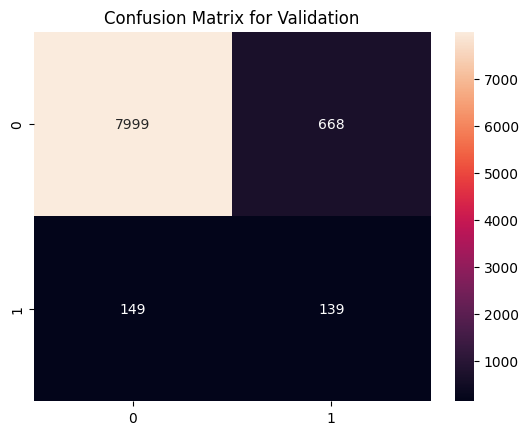

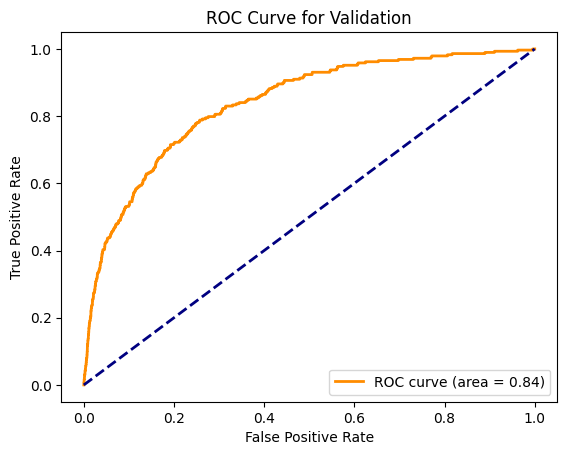

Threshold at Specificity 95.00%: 0.7823
Sensitivity at Specificity 95.00%: 0.4271


In [61]:
evaluate_model(model, val_generator, 'Validation')


156/156 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step

Metrics for Test Data:
Accuracy:  0.9110552763819095
Precision:  0.17861205915813425
Recall:  0.490625
F1-Score:  0.2618849040867389
AUC:  0.8349042705088265


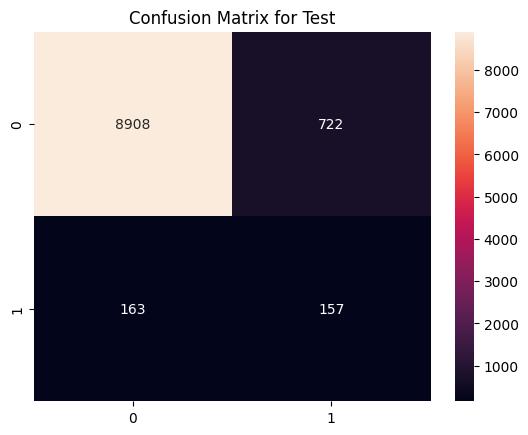

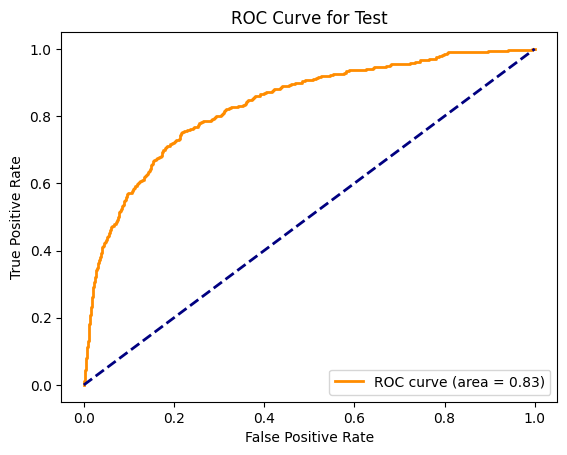

Threshold at Specificity 95.00%: 0.7797
Sensitivity at Specificity 95.00%: 0.4313


In [62]:
evaluate_model(model, test_generator, 'Test')

2438/2438 ━━━━━━━━━━━━━━━━━━━━ 3252s 1s/step

Metrics for Train Data:
Accuracy:  0.49960894929162125
Precision:  0.4996285063519324
Recall:  0.525931149432656
F1-Score:  0.5124425344793124
AUC:  0.4994541432849127


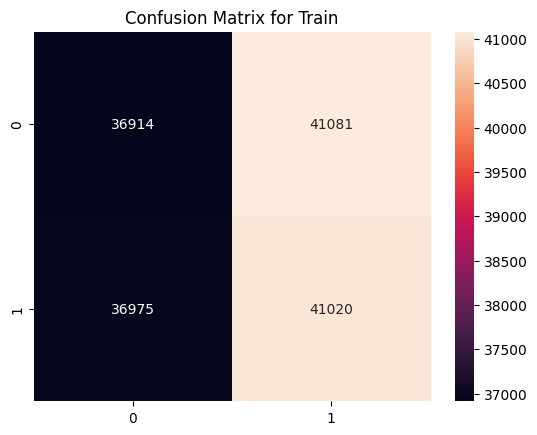

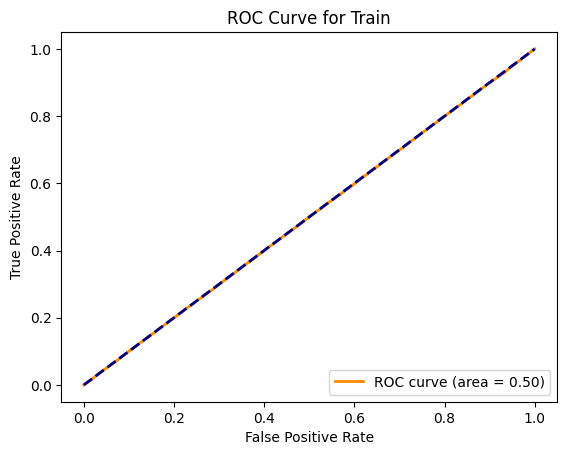

Threshold at Specificity 95.00%: 0.9990
Sensitivity at Specificity 95.00%: 0.0497


In [63]:
# Evaluate on Train, Validation, and Test Data
evaluate_model(model, train_generator, 'Train')

Monitor 2

In [64]:
# Subset for the test dataset
nrg_test = data[data['Final Label'] == 'NRG'].sample(n=2000, random_state=42)
rg_test = data[data['Final Label'] == 'RG'].sample(n=500, random_state=42)
test_data = pd.concat([nrg_test, rg_test])

In [65]:
# Remove the test data from the original dataset
data_remaining = data.drop(test_data.index)

In [66]:

# Separate remaining NRG and RG
nrg_remaining = data_remaining[data_remaining['Final Label'] == 'NRG']
rg_remaining = data_remaining[data_remaining['Final Label'] == 'RG']

In [67]:
# Undersample NRG and oversample RG
nrg_undersampled = resample(nrg_remaining, replace=False, n_samples=60000, random_state=42)
rg_oversampled = resample(rg_remaining, replace=True, n_samples=15000, random_state=42)

In [68]:
# Combine undersampled and oversampled data
balanced_data = pd.concat([nrg_undersampled, rg_oversampled])

In [69]:
# Split balanced data into training and validation sets (80-20 split)
train_data, val_data = train_test_split(balanced_data, test_size=0.2, random_state=42, stratify=balanced_data['Final Label'])

In [70]:
print(f"Training Set: {train_data.shape}")
print(f"Validation Set: {val_data.shape}")
print(f"Test Set: {test_data.shape}")

Training Set: (60000, 39)
Validation Set: (15000, 39)
Test Set: (2500, 39)


In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [72]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid'),
])

/home/iiitd/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [73]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])


In [74]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,795,649 (182.33 MB)

 Trainable params: 47,795,649 (182.33 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Prepare your data generators
# Assuming you have train_data and val_data as DataFrames with file paths and labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [76]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



In [77]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='File Path',
    y_col='Final Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='File Path',
    y_col='Final Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='File Path',
    y_col='Final Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 60000 validated image filenames belonging to 2 classes.
Found 15000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [78]:
# Load the model
model = load_model('monitor2model.h5')



  1/469 ━━━━━━━━━━━━━━━━━━━━ 1:07 145ms/step

/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step

Metrics for Validation Data:
Accuracy:  0.6702
Precision:  0.19795221843003413
Recall:  0.21266666666666667
F1-Score:  0.20504579784669774
AUC:  0.4953981805555556


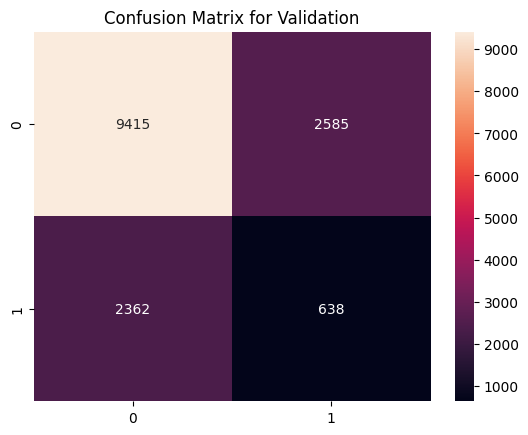

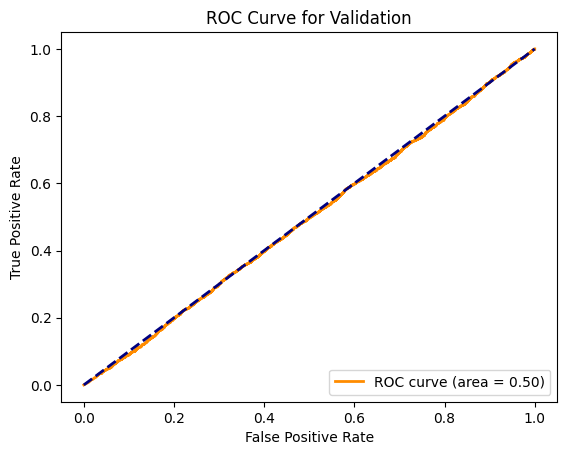

Threshold at Specificity 95.00%: 0.9999
Sensitivity at Specificity 95.00%: 0.0463


In [79]:
evaluate_model(model, val_generator, 'Validation')


 1/79 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step

/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step

Metrics for Test Data:
Accuracy:  0.6724
Precision:  0.20186915887850468
Recall:  0.216
F1-Score:  0.20869565217391303
AUC:  0.49381650000000005


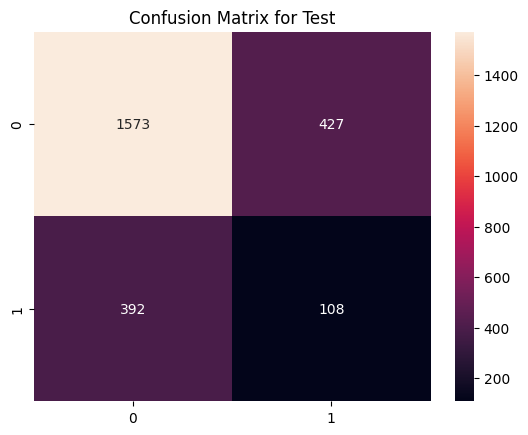

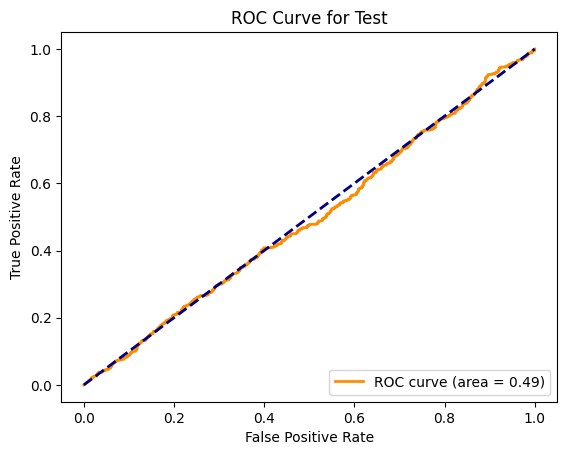

Threshold at Specificity 95.00%: 0.9999
Sensitivity at Specificity 95.00%: 0.0460


In [80]:
evaluate_model(model, test_generator, 'Test')


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 4:03 130ms/step

/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 216s 115ms/step

Metrics for Train Data:
Accuracy:  0.6719
Precision:  0.20004683109584764
Recall:  0.21358333333333332
F1-Score:  0.2065935837497985
AUC:  0.49934017361111116


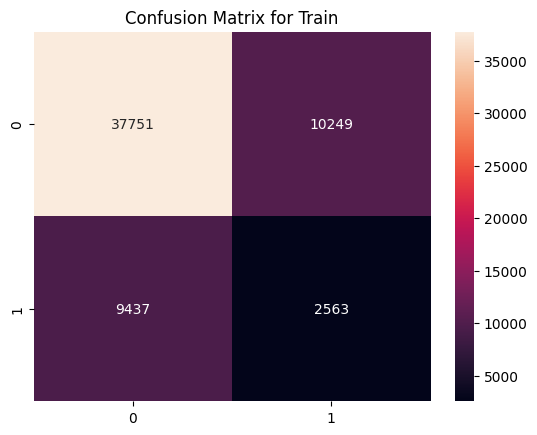

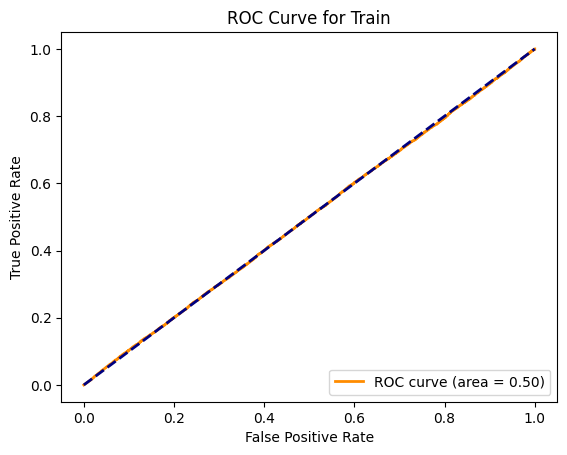

Threshold at Specificity 95.00%: 0.9999
Sensitivity at Specificity 95.00%: 0.0531


In [81]:
evaluate_model(model,train_generator,'Train')

Monitor 3

In [92]:
data = pd.read_csv('JustRAIGS_Train_labels.csv', delimiter=';')
# data = data[:17400]
data.head()

,Eye ID,Final Label,Fellow Eye ID,Age,Label G1,Label G2,Label G3,G1 ANRS,G1 ANRI,G1 RNFLDS,...,G3 ANRS,G3 ANRI,G3 RNFLDS,G3 RNFLDI,G3 BCLVS,G3 BCLVI,G3 NVT,G3 DH,G3 LD,G3 LC
0,TRAIN000000,NRG,TRAIN081848,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN000001,NRG,TRAIN018312,29.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAIN000002,NRG,TRAIN083822,61.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN000003,NRG,TRAIN055721,70.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TRAIN000004,NRG,TRAIN099283,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
image_directory= 'images/combine'
def get_extension(eye_id):
    for ext in ['.JPG', '.JPEG', '.PNG']:  # Check for common image extensions
        image_path = os.path.join(image_directory, f"{eye_id}{ext}")
        if os.path.exists(image_path):
            return f"{ext}"
    print(f"Image not found for {eye_id}")
    return None

In [94]:
# add column File Path
data['Extention'] = data['Eye ID'].apply(lambda x: get_extension(x))
data['File Path'] = 'images/combine/' + data['Eye ID'] + data['Extention']

In [95]:
data['File Path'] = 'cropped_images/' + data['Eye ID'] + data['Extention']

In [96]:
data

,Eye ID,Final Label,Fellow Eye ID,Age,Label G1,Label G2,Label G3,G1 ANRS,G1 ANRI,G1 RNFLDS,...,G3 RNFLDS,G3 RNFLDI,G3 BCLVS,G3 BCLVI,G3 NVT,G3 DH,G3 LD,G3 LC,Extention,File Path
0,TRAIN000000,NRG,TRAIN081848,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000000.JPG
1,TRAIN000001,NRG,TRAIN018312,29.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000001.JPG
2,TRAIN000002,NRG,TRAIN083822,61.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000002.JPG
3,TRAIN000003,NRG,TRAIN055721,70.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000003.JPG
4,TRAIN000004,NRG,TRAIN099283,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN000004.JPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101418,TRAIN101437,NRG,TRAIN096656,57.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN101437.JPG
101419,TRAIN101438,NRG,TRAIN078075,52.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN101438.JPG
101420,TRAIN101439,NRG,TRAIN056754,49.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN101439.JPG
101421,TRAIN101440,NRG,TRAIN040796,44.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.JPG,cropped_images/TRAIN101440.JPG


In [97]:
X = data[['Eye ID', 'Final Label', 'Fellow Eye ID', 'Age', 'File Path', 'Extention']]
y = data['Final Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)
print(X_train.shape, X_val.shape, X_test.shape)

(82152, 6) (9128, 6) (10143, 6)


In [98]:
def get_image_generator(df, image_size=(128, 128), batch_size=32, shuffle=True):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        # width_shift_range=0.05,
        # height_shift_range=0.05,
        # zoom_range=0.2,
        # horizontal_flip=True,
        # fill_mode='nearest',
    )
    generator = datagen.flow_from_dataframe(
        df,
        x_col='File Path',
        y_col='Final Label',
        target_size=image_size,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=shuffle
    )
    return generator

In [99]:
from sklearn.utils import resample
X_train_rg = X_train[X_train['Final Label']=='RG']
X_train_nrg = X_train[X_train['Final Label']=='NRG']
X_train_rg.shape, X_train_nrg.shape

((2649, 6), (79503, 6))

In [85]:
X_train_rg_resampled= resample(X_train_rg, n_samples= 10000, random_state= seed)
X_train_nrg_resampled= resample(X_train_nrg, n_samples= 10000, random_state= seed)
X_train_rg_resampled.shape, X_train_nrg_resampled

((10000, 6),
             Eye ID Final Label Fellow Eye ID   Age  \
 48862  TRAIN048871         NRG   TRAIN090471  59.0   
 57508  TRAIN057519         NRG   TRAIN003913  63.0   
 52579  TRAIN052589         NRG   TRAIN029761  55.0   
 97109  TRAIN097127         NRG   TRAIN063181  62.0   
 37955  TRAIN037964         NRG   TRAIN070498  58.0   
 ...            ...         ...           ...   ...   
 58476  TRAIN058487         NRG   TRAIN018773  78.0   
 65547  TRAIN065559         NRG   TRAIN090211  56.0   
 29222  TRAIN029229         NRG   TRAIN042452  40.0   
 64515  TRAIN064527         NRG   TRAIN006544  54.0   
 89749  TRAIN089764         NRG   TRAIN007846  37.0   
 
                             File Path Extention  
 48862  cropped_images/TRAIN048871.JPG      .JPG  
 57508  cropped_images/TRAIN057519.JPG      .JPG  
 52579  cropped_images/TRAIN052589.JPG      .JPG  
 97109  cropped_images/TRAIN097127.JPG      .JPG  
 37955  cropped_images/TRAIN037964.JPG      .JPG  
 ...               

In [100]:
X_train_resampled = pd.concat([X_train_rg_resampled, X_train_nrg_resampled])
X_train_resampled.shape

(20000, 6)

In [101]:
# Define the ImageDataGenerator for oversampled data
train_generator = get_image_generator(X_train_resampled, image_size=(120, 200), batch_size=64, shuffle=True)

Found 20000 validated image filenames belonging to 2 classes.


In [102]:
# train_generator = get_image_generator(X_train, image_size=(90, 150), batch_size=32, shuffle=True)
val_generator = get_image_generator(X_val, image_size=(120, 200), batch_size=64, shuffle=False)

Found 8971 validated image filenames belonging to 2 classes.


/home/iiitd/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 157 invalid image filename(s) in x_col="File Path". These filename(s) will be ignored.
  warnings.warn(


In [113]:
test_generator = get_image_generator(X_test, image_size=(120, 200), batch_size=64, shuffle=False)

Found 9922 validated image filenames belonging to 2 classes.


/home/iiitd/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 221 invalid image filename(s) in x_col="File Path". These filename(s) will be ignored.
  warnings.warn(


In [103]:
print(f'train 0: {train_generator.classes.count(0)}\ntrain 1: {train_generator.classes.count(1)}')

train 0: 10000
train 1: 10000


In [104]:
imbalance_ratio= (train_generator.classes.count(0)// train_generator.classes.count(1))
print(imbalance_ratio)

1


In [105]:
print(f'val 0: {val_generator.classes.count(0)}\nval 1: {val_generator.classes.count(1)}')

val 0: 8682
val 1: 289


In [106]:
from tensorflow.keras.layers import Input
from keras.applications import VGG16, DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

def get_model(input_shape):
    input_layer = Input(shape=input_shape)
    base_model = VGG16(include_top=False, input_tensor=input_layer)

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

    # model = keras.Sequential([
    #     layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    #     layers.AveragePooling2D((2, 2)),
    #     layers.Conv2D(64, (3, 3), activation='relu'),
    #     layers.AveragePooling2D((2, 2)),
    #     layers.Conv2D(128, (3, 3), activation='relu'),
    #     layers.AveragePooling2D((2, 2)),
    #     layers.Flatten(),
    #     layers.Dense(128, activation='relu'),
    #     layers.Dropout(0.1),
    #     layers.Dense(128, activation='relu'),
    #     layers.Dropout(0.1),
    #     layers.Dense(1, activation='sigmoid')
    # ])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
    return model


In [107]:
model = get_model((120,200, 3))
model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 120, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 120, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 120, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 60, 100, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 60, 100, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 60, 100, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 30, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 30, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 30, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 30, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 15, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 15, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 15, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 15, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 7, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           12

 Total params: 15,911,105 (60.70 MB)

 Trainable params: 1,196,417 (4.56 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [108]:
weight= {0: 1, 1: imbalance_ratio}

In [109]:
from keras.models import load_model

# Define your model architecture again
 # This should be the function that creates your model architecture

# Load weights into the model
model.load_weights('model_weights_epoch_20.weights.h5')

/home/iiitd/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [110]:
def evaluate_model(model, data_generator, dataset_name='Train'):
    predictions = model.predict(data_generator)
    predictions_prob = predictions # Save the probabilities for ROC curve
    predictions = (predictions > 0.5).astype(int)
    true_labels = data_generator.classes
    print(f"\nMetrics for {dataset_name} Data:")
    print("Accuracy: ", accuracy_score(true_labels, predictions))
    print("Precision: ", precision_score(true_labels, predictions))
    print("Recall: ", recall_score(true_labels, predictions))
    print("F1-Score: ", f1_score(true_labels, predictions))
    print("AUC: ", roc_auc_score(true_labels, predictions_prob))
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, predictions_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Desired specificity
    desired_specificity = 0.95
    idx = np.argmax(fpr >= (1 - desired_specificity))
    threshold_at_desired_specificity = thresholds[idx]
    sensitivity_at_desired_specificity = tpr[idx]

    print(f"Threshold at Specificity {desired_specificity*100:.2f}%: {threshold_at_desired_specificity:.4f}")
    print(f"Sensitivity at Specificity {desired_specificity*100:.2f}%: {sensitivity_at_desired_specificity:.4f}")


/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step

Metrics for Validation Data:
Accuracy:  0.7984617099542972
Precision:  0.11190597853857946
Recall:  0.7577854671280276
F1-Score:  0.195013357079252
AUC:  0.839571431645954


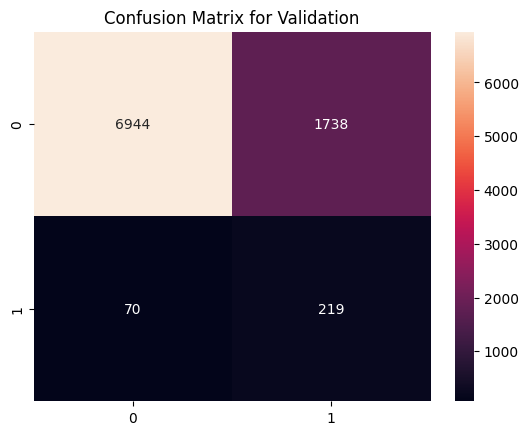

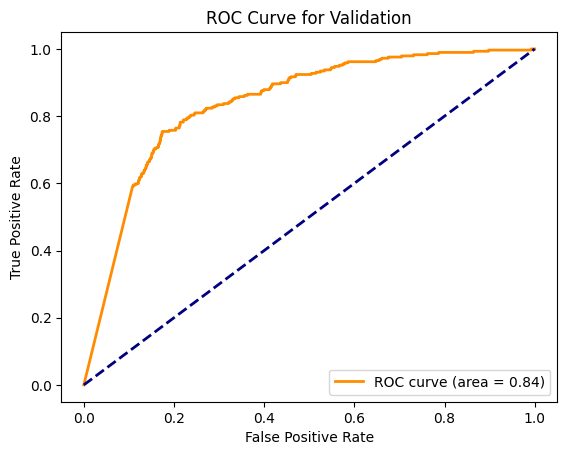

Threshold at Specificity 95.00%: 0.8332
Sensitivity at Specificity 95.00%: 0.5917


In [111]:
evaluate_model(model, val_generator, 'Validation')


/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step

Metrics for Test Data:
Accuracy:  0.8013505341664987
Precision:  0.11453950444132772
Recall:  0.7608695652173914
F1-Score:  0.19910605444941082
AUC:  0.8408899456521739


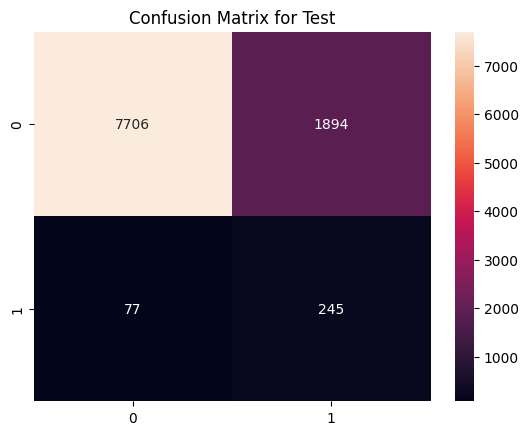

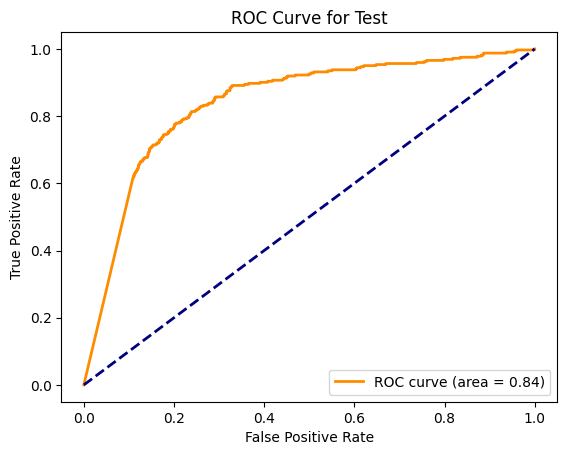

Threshold at Specificity 95.00%: 0.8332
Sensitivity at Specificity 95.00%: 0.6149


In [114]:
evaluate_model(model, test_generator, 'Test')


/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step

Metrics for Train Data:
Accuracy:  0.50525
Precision:  0.5047670934350313
Recall:  0.5559
F1-Score:  0.5291010326940465
AUC:  0.504520375


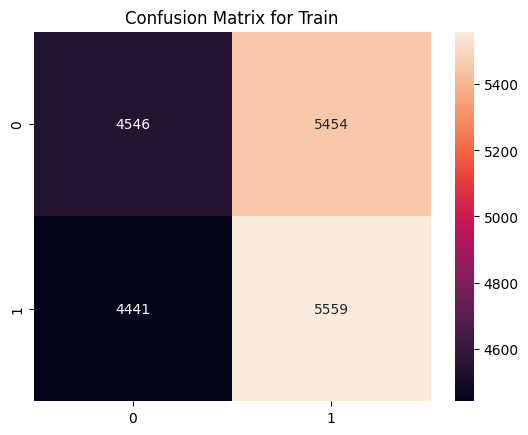

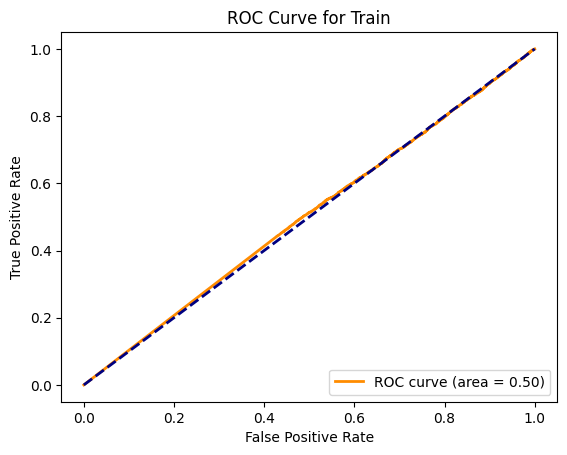

Threshold at Specificity 95.00%: 0.8332
Sensitivity at Specificity 95.00%: 0.4395


In [115]:
evaluate_model(model, train_generator, 'Train')


Monitor 4

In [134]:
seed= 1
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [135]:
data = pd.read_csv('JustRAIGS_Train_labels.csv', delimiter=';')
# data = data[:17400]
data.head()

,Eye ID,Final Label,Fellow Eye ID,Age,Label G1,Label G2,Label G3,G1 ANRS,G1 ANRI,G1 RNFLDS,...,G3 ANRS,G3 ANRI,G3 RNFLDS,G3 RNFLDI,G3 BCLVS,G3 BCLVI,G3 NVT,G3 DH,G3 LD,G3 LC
0,TRAIN000000,NRG,TRAIN081848,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN000001,NRG,TRAIN018312,29.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAIN000002,NRG,TRAIN083822,61.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN000003,NRG,TRAIN055721,70.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TRAIN000004,NRG,TRAIN099283,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
image_directory= 'images/combine'
def get_extension(eye_id):
    for ext in ['.JPG', '.JPEG', '.PNG']:  # Check for common image extensions
        image_path = os.path.join(image_directory, f"{eye_id}{ext}")
        if os.path.exists(image_path):
            return f"{ext}"
    print(f"Image not found for {eye_id}")
    return None

# add column File Path
data['Extention'] = data['Eye ID'].apply(lambda x: get_extension(x))
data['File Path'] = 'images/combine/' + data['Eye ID'] + data['Extention']

In [137]:
data['File Path'] = 'cropped_images/' + data['Eye ID'] + data['Extention']

In [138]:
X = data[['Eye ID', 'Final Label', 'Fellow Eye ID', 'Age', 'File Path', 'Extention']]
y = data['Final Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)
print(X_train.shape, X_val.shape, X_test.shape)

(82152, 6) (9128, 6) (10143, 6)


In [139]:
def get_image_generator(df, image_size=(128, 128), batch_size=32, shuffle=True):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        # width_shift_range=0.05,
        # height_shift_range=0.05,
        # zoom_range=0.2,
        # horizontal_flip=True,
        # fill_mode='nearest',
    )
    generator = datagen.flow_from_dataframe(
        df,
        x_col='File Path',
        y_col='Final Label',
        target_size=image_size,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=shuffle
    )
    return generator

In [140]:
from sklearn.utils import resample
X_train_rg = X_train[X_train['Final Label']=='RG']
X_train_nrg = X_train[X_train['Final Label']=='NRG']
X_train_rg.shape, X_train_nrg.shape

((2649, 6), (79503, 6))

In [141]:
X_train_rg_resampled= resample(X_train_rg, n_samples= 15000, random_state= seed)
X_train_nrg_resampled= resample(X_train_nrg, n_samples= 60000, random_state= seed)
X_train_rg_resampled.shape, X_train_nrg_resampled

((15000, 6),
             Eye ID Final Label Fellow Eye ID   Age  \
 99909  TRAIN099927         NRG   TRAIN064012  55.0   
 85185  TRAIN085200         NRG   TRAIN019221  55.0   
 76720  TRAIN076734         NRG   TRAIN066830  49.0   
 4512   TRAIN004512         NRG   TRAIN071533  56.0   
 67824  TRAIN067836         NRG   TRAIN094612  61.0   
 ...            ...         ...           ...   ...   
 66483  TRAIN066495         NRG           NaN  51.0   
 50001  TRAIN050010         NRG           NaN  65.0   
 33777  TRAIN033785         NRG   TRAIN053200  66.0   
 36607  TRAIN036616         NRG   TRAIN020370  76.0   
 82042  TRAIN082057         NRG   TRAIN023360  72.0   
 
                             File Path Extention  
 99909  cropped_images/TRAIN099927.JPG      .JPG  
 85185  cropped_images/TRAIN085200.JPG      .JPG  
 76720  cropped_images/TRAIN076734.JPG      .JPG  
 4512   cropped_images/TRAIN004512.JPG      .JPG  
 67824  cropped_images/TRAIN067836.JPG      .JPG  
 ...               

In [142]:
X_train_resampled = pd.concat([X_train_rg_resampled, X_train_nrg_resampled])
X_train_resampled.shape

(75000, 6)

In [143]:
# Define the ImageDataGenerator for oversampled data
train_generator = get_image_generator(X_train_resampled, image_size=(120, 200), batch_size=64, shuffle=True)

Found 73514 validated image filenames belonging to 2 classes.


/home/iiitd/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1486 invalid image filename(s) in x_col="File Path". These filename(s) will be ignored.
  warnings.warn(


In [144]:
# train_generator = get_image_generator(X_train, image_size=(90, 150), batch_size=32, shuffle=True)
val_generator = get_image_generator(X_val, image_size=(120, 200), batch_size=64, shuffle=False)

Found 8971 validated image filenames belonging to 2 classes.


/home/iiitd/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 157 invalid image filename(s) in x_col="File Path". These filename(s) will be ignored.
  warnings.warn(


In [145]:
test_generator = get_image_generator(X_test, image_size=(120, 200), batch_size=64, shuffle=False)

Found 9922 validated image filenames belonging to 2 classes.


/home/iiitd/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 221 invalid image filename(s) in x_col="File Path". These filename(s) will be ignored.
  warnings.warn(


In [146]:
print(f'train 0: {train_generator.classes.count(0)}\ntrain 1: {train_generator.classes.count(1)}')

train 0: 58859
train 1: 14655


In [147]:
imbalance_ratio= (train_generator.classes.count(0)// train_generator.classes.count(1))
print(imbalance_ratio)

4


In [148]:
print(f'val 0: {val_generator.classes.count(0)}\nval 1: {val_generator.classes.count(1)}')

val 0: 8682
val 1: 289


In [149]:
from tensorflow.keras.layers import Input
from keras.applications import VGG16, DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

def get_model(input_shape):
    input_layer = Input(shape=input_shape)
    base_model = VGG16(include_top=False, input_tensor=input_layer)

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

    # model = keras.Sequential([
    #     layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    #     layers.AveragePooling2D((2, 2)),
    #     layers.Conv2D(64, (3, 3), activation='relu'),
    #     layers.AveragePooling2D((2, 2)),
    #     layers.Conv2D(128, (3, 3), activation='relu'),
    #     layers.AveragePooling2D((2, 2)),
    #     layers.Flatten(),
    #     layers.Dense(128, activation='relu'),
    #     layers.Dropout(0.1),
    #     layers.Dense(128, activation='relu'),
    #     layers.Dropout(0.1),
    #     layers.Dense(1, activation='sigmoid')
    # ])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
    return model

In [150]:
model = get_model((120,200, 3))
model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 120, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 120, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 120, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 60, 100, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 60, 100, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 60, 100, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 30, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 30, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 30, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 30, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 15, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 15, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 15, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 15, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 7, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           12

 Total params: 15,911,105 (60.70 MB)

 Trainable params: 1,196,417 (4.56 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [151]:
best_model= load_model('monitor04model.h5')

In [152]:
def evaluate_model(model, data_generator, dataset_name='Train'):
    predictions = model.predict(data_generator)
    predictions_prob = predictions # Save the probabilities for ROC curve
    predictions = (predictions > 0.5).astype(int)
    true_labels = data_generator.classes
    print(f"\nMetrics for {dataset_name} Data:")
    print("Accuracy: ", accuracy_score(true_labels, predictions))
    print("Precision: ", precision_score(true_labels, predictions))
    print("Recall: ", recall_score(true_labels, predictions))
    print("F1-Score: ", f1_score(true_labels, predictions))
    print("AUC: ", roc_auc_score(true_labels, predictions_prob))
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, predictions_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Desired specificity
    desired_specificity = 0.95
    idx = np.argmax(fpr >= (1 - desired_specificity))
    threshold_at_desired_specificity = thresholds[idx]
    sensitivity_at_desired_specificity = tpr[idx]

    print(f"Threshold at Specificity {desired_specificity*100:.2f}%: {threshold_at_desired_specificity:.4f}")
    print(f"Sensitivity at Specificity {desired_specificity*100:.2f}%: {sensitivity_at_desired_specificity:.4f}")


141/141 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step

Metrics for Validation Data:
Accuracy:  0.9656671497046038
Precision:  0.4558139534883721
Recall:  0.3391003460207612
F1-Score:  0.3888888888888889
AUC:  0.9240246893505156


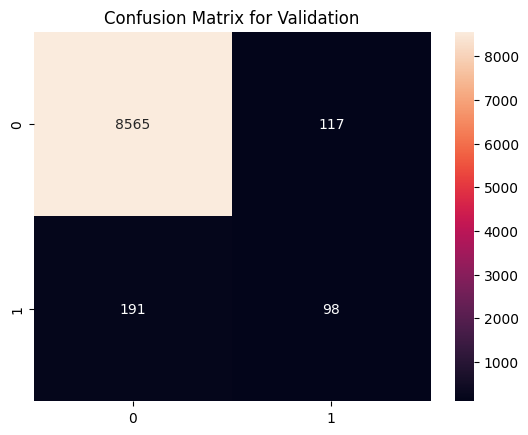

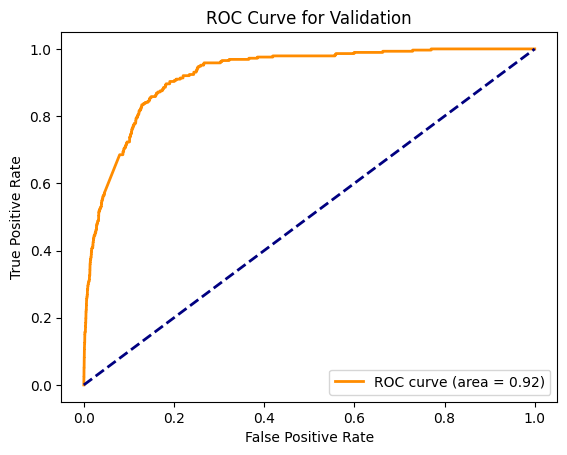

Threshold at Specificity 95.00%: 0.2718
Sensitivity at Specificity 95.00%: 0.6851


In [132]:
evaluate_model(best_model, val_generator, 'Validation')



141/141 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step

Metrics for Validation Data:
Accuracy:  0.9656671497046038
Precision:  0.4558139534883721
Recall:  0.3391003460207612
F1-Score:  0.3888888888888889
AUC:  0.9240246893505156


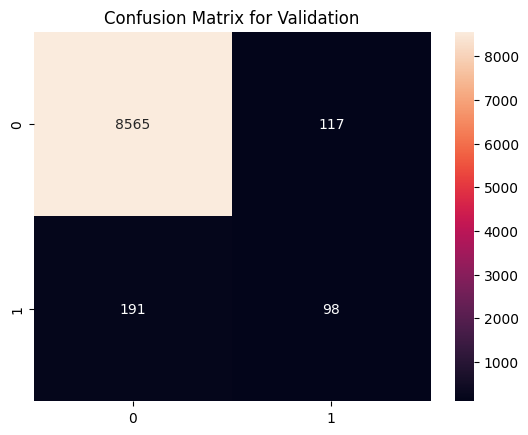

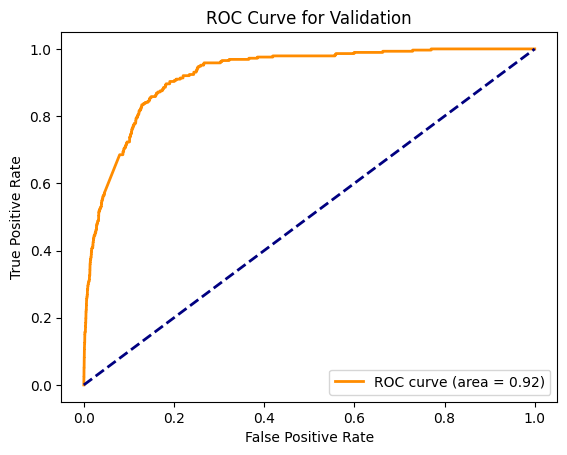

Threshold at Specificity 95.00%: 0.2718
Sensitivity at Specificity 95.00%: 0.6851


In [ ]:
evaluate_model(best_model, val_generator, 'Validation')



/home/iiitd/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step

Metrics for Test Data:
Accuracy:  0.9666397903648458
Precision:  0.4817813765182186
Recall:  0.3695652173913043
F1-Score:  0.4182776801405975
AUC:  0.9199577833850932


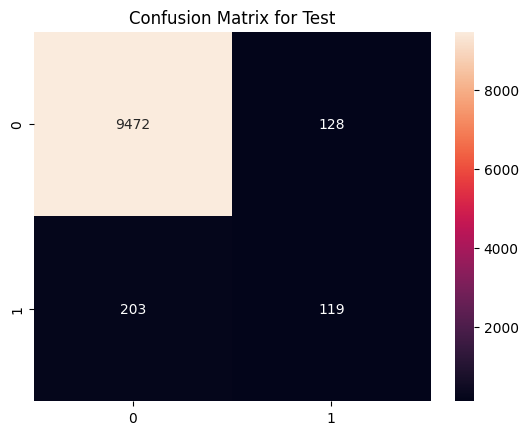

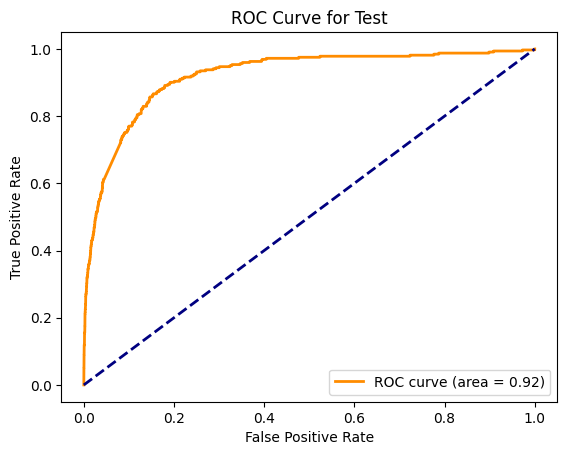

Threshold at Specificity 95.00%: 0.2718
Sensitivity at Specificity 95.00%: 0.7205


In [133]:
evaluate_model(best_model, test_generator, 'Test')